In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor


In [2]:
from dask.distributed import Client

# Suppose you reserved one node with 32 cores:
client = Client(n_workers=32, threads_per_worker=1)

In [3]:
# Read feature descriptors
X = pd.read_csv('inner_averaged_local_soap_mofs.csv')

# Read labels
y = pd.read_csv('id_labels.csv')


In [4]:
print(X.shape)
print(y.shape)

(3089, 485)
(3089, 2)


In [5]:
X['filename'] = X['filename'].str.replace('.cif', ' ', regex=False)

In [6]:
X.head()

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
0,0.606729,4.104813e-04,1.960778,-9.536714e-04,0.768790,4.918767e-04,0.169485,0.000051,6.336679,2.239353e-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.402389,1.178922e-34,0.821303,1.204494e-34,0.106896,4.971153e-35,0.000000,0.000000,1.676335,2.619894e-33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.169435,2.121687e-08,2.936747,-4.895232e-09,0.929966,-1.669589e-08,0.000000,0.000000,7.374917,1.214716e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.919702,5.012132e-06,0.219880,5.165943e-10,0.337257,-7.402103e-06,0.000000,0.000000,0.052568,8.266590e-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.864411,1.313350e-04,4.267314,-1.214154e-04,0.529791,-2.814131e-06,0.000000,0.000000,9.767143,1.129896e-04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
y.head()

,id,label
0,DB5-hypotheticalMOF_17652_0_0_1_21_9_7_repeat,13.791591
1,DB0-m2_o8_o23_f0_pcu.sym.80_repeat,3.786996
2,DB0-m29_o90_o1500_f0_pts.sym.31_repeat,9.382537
3,DB0-m3_o48_o25_f0_fsc.sym.3_repeat,11.650365
4,DB0-m2_o1_o9_f0_nbo.sym.104_repeat,1.412915


In [8]:
X.set_index('filename', inplace = True)

In [9]:
y.set_index('id', inplace = True)

In [10]:
X.sort_index(inplace=True)

In [11]:
y.sort_index(inplace=True)

In [12]:
print("Are they exactly equal?", (X.index == y.index).all())

Are they exactly equal? True


In [13]:
X

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,2.372481,4.789053e-05,4.566619,-2.847807e-05,0.000000,0.000000e+00,0.0,0.0,8.789958,4.604714e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,2.664352,4.912572e-07,5.727196,-3.015680e-07,0.000000,0.000000e+00,0.0,0.0,12.310976,1.888190e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,1.867885,7.554781e-05,0.102569,-1.095441e-07,0.117701,-3.615372e-08,0.0,0.0,0.005632,3.363876e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,1.766971,6.000793e-04,0.130872,-8.292492e-06,0.145389,-3.116756e-05,0.0,0.0,0.009693,1.654415e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,1.447146,1.341172e-33,0.122311,3.565144e-35,0.135989,6.692572e-35,0.0,0.0,0.010338,4.263919e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,1.867374,1.895562e-05,0.667778,-1.157837e-05,0.178633,-1.122160e-06,0.0,0.0,0.238799,1.984810e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,0.959467,2.392761e-05,0.216207,1.091064e-06,0.151780,-1.555363e-05,0.0,0.0,0.048720,6.314131e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,10.770907,2.946942e-05,1.643993,-1.057452e-05,0.257595,-2.599308e-06,0.0,0.0,0.250927,2.213199e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.173793,-0.000002,0.0,0.0


In [14]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
X

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,2.372481,4.789053e-05,4.566619,-2.847807e-05,0.000000,0.000000e+00,0.0,0.0,8.789958,4.604714e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,2.664352,4.912572e-07,5.727196,-3.015680e-07,0.000000,0.000000e+00,0.0,0.0,12.310976,1.888190e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,1.867885,7.554781e-05,0.102569,-1.095441e-07,0.117701,-3.615372e-08,0.0,0.0,0.005632,3.363876e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,1.766971,6.000793e-04,0.130872,-8.292492e-06,0.145389,-3.116756e-05,0.0,0.0,0.009693,1.654415e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,1.447146,1.341172e-33,0.122311,3.565144e-35,0.135989,6.692572e-35,0.0,0.0,0.010338,4.263919e-36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,1.867374,1.895562e-05,0.667778,-1.157837e-05,0.178633,-1.122160e-06,0.0,0.0,0.238799,1.984810e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,0.959467,2.392761e-05,0.216207,1.091064e-06,0.151780,-1.555363e-05,0.0,0.0,0.048720,6.314131e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,10.770907,2.946942e-05,1.643993,-1.057452e-05,0.257595,-2.599308e-06,0.0,0.0,0.250927,2.213199e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.173793,-0.000002,0.0,0.0


In [17]:
# Step 1: Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3: Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 276435483917149.9
R² Score: -1.2984346310909144e+27


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)



/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [19]:
# Evaluate
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 4.286655769915853
Random Forest R²: 0.6877735211639563


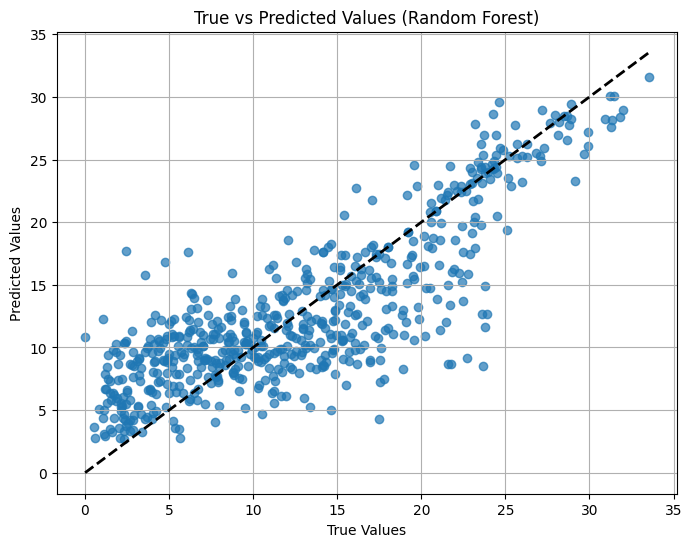

In [20]:
# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Plot a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Labels
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

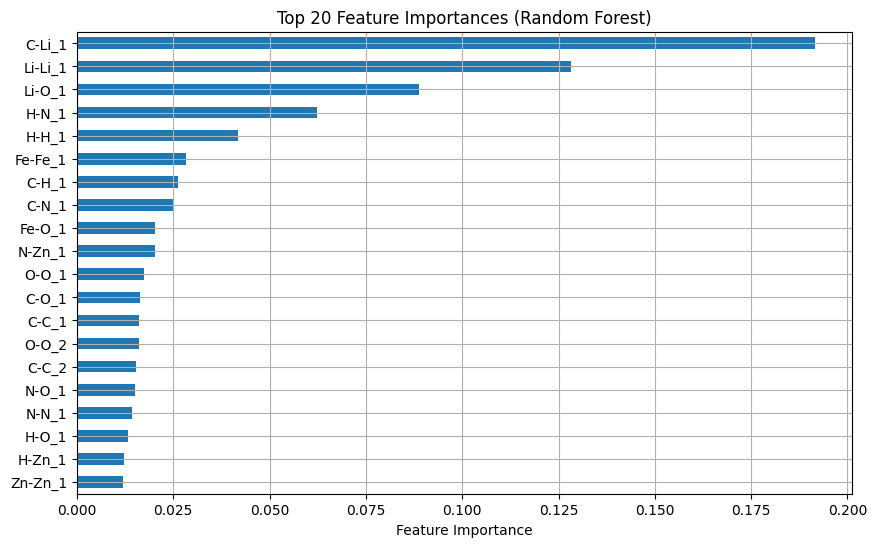

In [21]:
# 1. Get feature importances
importances = rf.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# 3. Sort them descending
feature_importances = feature_importances.sort_values(ascending=False)

# 4. Plot the top N features
top_n = 20  # you can change to top 10, 20, etc.

plt.figure(figsize=(10, 6))
feature_importances[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.grid(True)
plt.show()

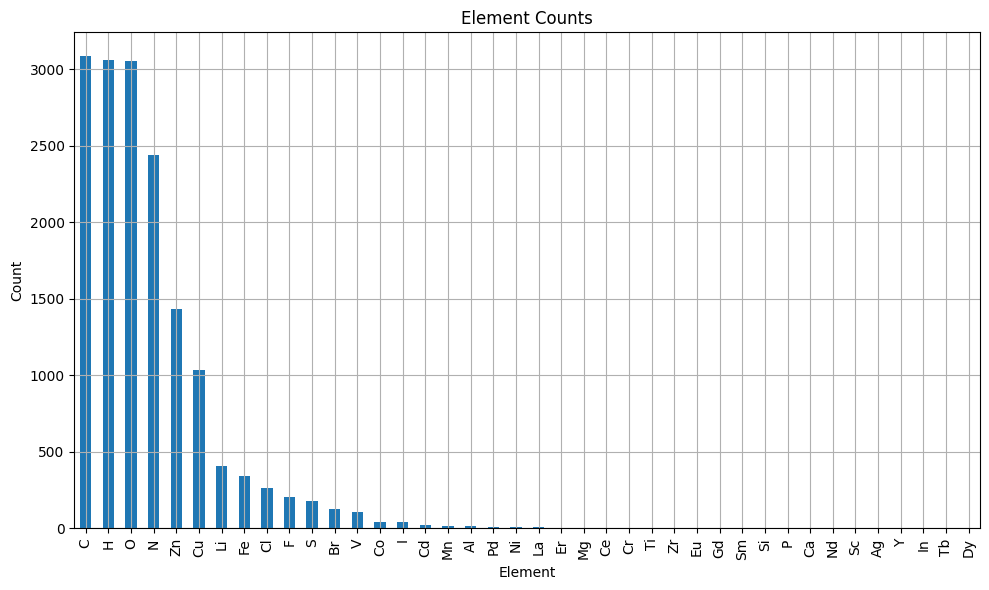

In [22]:
# Your dictionary
element_counts = {
    'C': 3087, 'H': 3062, 'O': 3052, 'N': 2439, 'Zn': 1437, 'Cu': 1034,
    'Li': 407, 'Fe': 345, 'Cl': 262, 'F': 205, 'S': 180, 'Br': 128,
    'V': 109, 'Co': 45, 'I': 41, 'Cd': 21, 'Mn': 13, 'Al': 13,
    'Pd': 11, 'Ni': 9, 'La': 8, 'Er': 6, 'Mg': 6, 'Ce': 5,
    'Cr': 4, 'Ti': 4, 'Zr': 4, 'Eu': 3, 'Nd': 2, 'Ca': 2,
    'P': 2, 'Gd': 2, 'Si': 2, 'Sm': 2, 'Sc': 1, 'Ag': 1,
    'Y': 1, 'In': 1, 'Tb': 1, 'Dy': 1
}

# Convert to a pandas Series
elements = pd.Series(element_counts)

# Sort by counts (descending)
elements = elements.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
elements.plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Element')
plt.title('Element Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Train-test split (again)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# XGBoost model
xgbr = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
xgbr.fit(X_train, y_train)

# Predict
y_pred_xgb = xgbr.predict(X_test)

# Evaluate
print("XGBoost RMSE:", root_mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))

XGBoost RMSE: 4.255484450774271
XGBoost R²: 0.6922978523607929


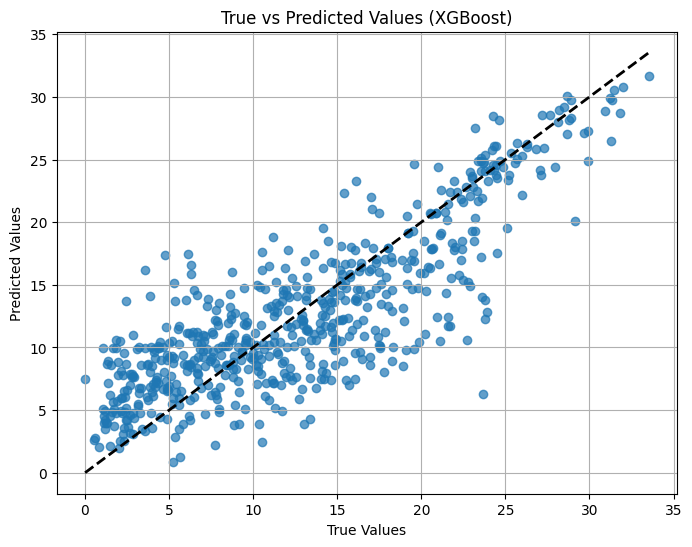

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (XGBoost)')
plt.grid(True)
plt.show()

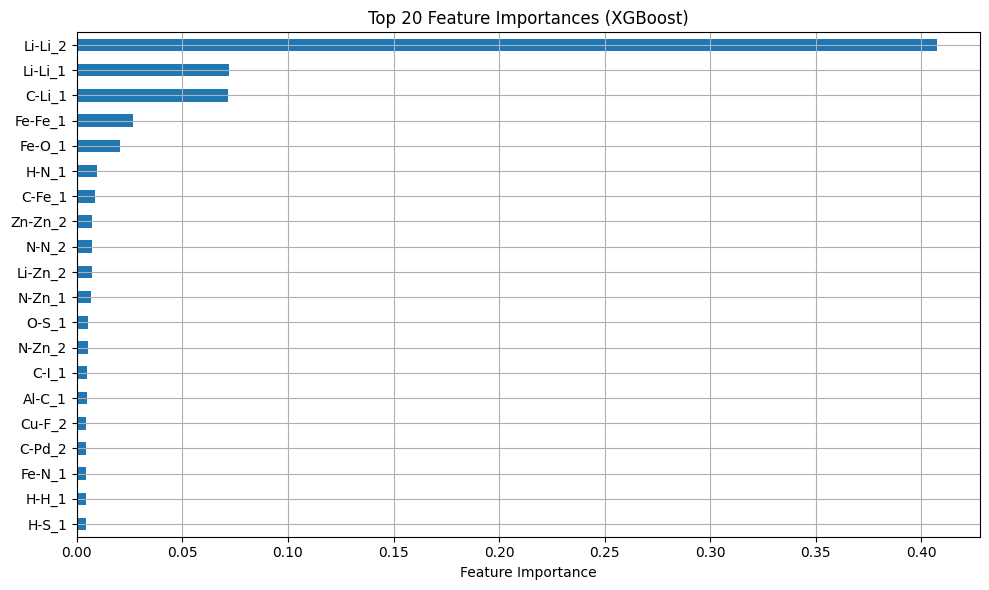

In [25]:
# 1. Get feature importances
importances_xgb = xgbr.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances_xgb = pd.Series(importances_xgb, index=feature_names)

# 3. Sort
feature_importances_xgb = feature_importances_xgb.sort_values(ascending=False)

# 4. Plot
top_n = 20

plt.figure(figsize=(10, 6))
feature_importances_xgb[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (XGBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 2. Initialize the MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(500, 10),  # 2 layers: first with 100 neurons, second with 50
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
)

# 3. Train
mlp.fit(X_train, y_train)

# 4. Predict
y_pred_mlp = mlp.predict(X_test)

# 5. Evaluate
print("MLP RMSE:", root_mean_squared_error(y_test, y_pred_mlp))
print("MLP R²:", r2_score(y_test, y_pred_mlp))

/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP RMSE: 5.191278609425064
MLP R²: 0.54208888373363


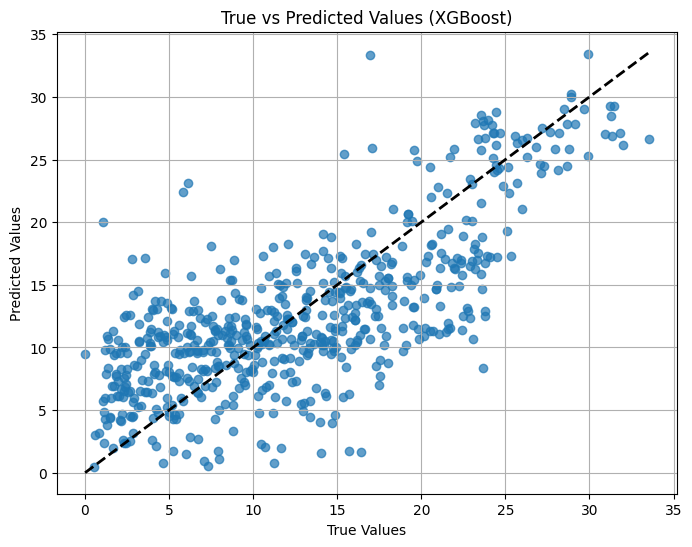

In [27]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_mlp, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (XGBoost)')
plt.grid(True)
plt.show()

In [28]:
from pycaret.regression import *

In [29]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [30]:
data = pd.concat([X, y], axis = 1)

In [31]:
data

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2,label
DB0-m12_o14_bcu_repeat,2.372481,4.789053e-05,4.566619,-2.847807e-05,0.000000,0.000000e+00,0.0,0.0,8.789958,4.604714e-05,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,16.427428
DB0-m12_o8_o32_tfz-d_repeat,2.664352,4.912572e-07,5.727196,-3.015680e-07,0.000000,0.000000e+00,0.0,0.0,12.310976,1.888190e-07,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,1.867885,7.554781e-05,0.102569,-1.095441e-07,0.117701,-3.615372e-08,0.0,0.0,0.005632,3.363876e-08,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,1.766971,6.000793e-04,0.130872,-8.292492e-06,0.145389,-3.116756e-05,0.0,0.0,0.009693,1.654415e-05,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,1.447146,1.341172e-33,0.122311,3.565144e-35,0.135989,6.692572e-35,0.0,0.0,0.010338,4.263919e-36,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.446165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,1.867374,1.895562e-05,0.667778,-1.157837e-05,0.178633,-1.122160e-06,0.0,0.0,0.238799,1.984810e-05,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.954847
DB7-ddmof_5786_repeat,0.959467,2.392761e-05,0.216207,1.091064e-06,0.151780,-1.555363e-05,0.0,0.0,0.048720,6.314131e-06,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.020765
DB7-ddmof_5952_repeat,10.770907,2.946942e-05,1.643993,-1.057452e-05,0.257595,-2.599308e-06,0.0,0.0,0.250927,2.213199e-05,...,0.0,0.0,0.0,0.0,0.0,0.173793,-0.000002,0.0,0.0,6.185781
DB7-ddmof_6321_repeat,0.050180,1.399220e-05,0.102698,4.866021e-07,0.025596,-6.318983e-06,0.0,0.0,0.210183,9.125261e-08,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.526927


In [32]:
exp1 = setup(data, target='label', session_id=123)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Regression
3,Original data shape,"(3089, 485)"
4,Transformed data shape,"(3089, 485)"
5,Transformed train set shape,"(2162, 485)"
6,Transformed test set shape,"(927, 485)"
7,Numeric features,484
8,Preprocess,True
9,Imputation type,simple


In [33]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.3603,18.9547,4.3512,0.6889,0.4644,1.6126,0.6100
lightgbm,Light Gradient Boosting Machine,3.4130,19.1641,4.3738,0.6856,0.4640,1.2016,52.1260
rf,Random Forest Regressor,3.4388,19.2703,4.3862,0.6847,0.4693,1.5656,0.9090
xgboost,Extreme Gradient Boosting,3.5190,20.5082,4.5240,0.6639,0.4784,1.1465,0.2530
gbr,Gradient Boosting Regressor,3.8558,22.1417,4.7028,0.6370,0.4959,1.5667,0.3960
knn,K Neighbors Regressor,3.9214,25.7025,5.0667,0.5780,0.5288,1.5285,0.0540
ada,AdaBoost Regressor,4.4369,28.1193,5.3000,0.5392,0.5613,1.7385,0.1920
br,Bayesian Ridge,4.3561,28.2783,5.3153,0.5362,0.5381,1.5055,0.1070
ridge,Ridge Regression,4.3438,28.2573,5.3130,0.5360,0.5375,1.5291,0.0870
omp,Orthogonal Matching Pursuit,4.3599,28.5137,5.3376,0.5317,0.5391,1.3456,0.0850


In [34]:
tuned_model_et = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8854,22.3937,4.7322,0.6748,0.5013,1.5667
1,3.8204,22.6243,4.7565,0.6369,0.4580,0.5474
2,3.8644,22.1940,4.7111,0.6728,0.5008,0.6763
3,4.1205,23.6696,4.8651,0.5876,0.5329,0.7739
4,3.6668,20.4364,4.5207,0.5982,0.5169,0.7193
5,3.8787,23.3052,4.8275,0.5810,0.5129,0.6748
6,4.1874,24.6691,4.9668,0.5742,0.4955,0.6300
7,4.2395,25.6841,5.0680,0.5982,0.5257,0.7112
8,4.2547,26.0756,5.1064,0.6020,0.5463,0.7643


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
tuned_model_lgbm = tune_model(create_model('lightgbm'))

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:26:42
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
tuned_model_rf = tune_model(create_model('rf'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5313,19.6762,4.4358,0.7142,0.4732,1.5934
1,3.2524,18.9306,4.3509,0.6962,0.3985,0.4089
2,3.3001,18.4641,4.2970,0.7278,0.4497,0.5607
3,3.5171,18.5020,4.3014,0.6777,0.4810,0.6362
4,3.2074,17.3204,4.1618,0.6595,0.4798,0.6126
5,3.1965,16.6729,4.0832,0.7002,0.4663,0.5753
6,3.6162,21.2216,4.6067,0.6337,0.4666,0.5389
7,3.7695,21.8715,4.6767,0.6578,0.4960,0.6315
8,3.5951,20.5994,4.5387,0.6856,0.5015,0.6417


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.7032,21.1454,4.5984,0.6929,0.4892,1.5994
1,3.4646,20.6465,4.5438,0.6687,0.4218,0.4507
2,3.5005,19.1974,4.3815,0.7169,0.4643,0.5950
3,3.7839,20.7602,4.5563,0.6383,0.4997,0.6889
4,3.3397,17.5217,4.1859,0.6555,0.4868,0.6430
5,3.4431,18.6544,4.3191,0.6646,0.4791,0.5994
6,3.8686,22.6084,4.7548,0.6097,0.4730,0.5609
7,3.9859,23.4368,4.8412,0.6333,0.5013,0.6426
8,3.8917,22.7063,4.7651,0.6535,0.5155,0.6868


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [36]:
tuned_model_xgb = tune_model(create_model('xgboost'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4692,19.2976,4.3929,0.7197,0.4702,1.1880
1,3.3204,19.8734,4.4580,0.6811,0.4085,0.4110
2,3.3683,19.2848,4.3914,0.7157,0.4417,0.5221
3,3.3964,18.8258,4.3389,0.6720,0.4838,0.6215
4,3.4533,20.2291,4.4977,0.6023,0.5045,0.6212
5,3.2993,17.6461,4.2007,0.6827,0.4682,0.5400
6,3.6789,21.2743,4.6124,0.6328,0.4732,0.5326
7,3.8508,23.7408,4.8725,0.6286,0.5088,0.6309
8,3.6893,21.4684,4.6334,0.6723,0.5094,0.6358


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5837,19.3988,4.4044,0.7183,0.4659,1.1766
1,3.4157,20.3250,4.5083,0.6738,0.4102,0.4307
2,3.3296,18.5139,4.3028,0.7270,0.4381,0.5266
3,3.5334,19.5294,4.4192,0.6598,0.5050,0.6879
4,3.3624,18.7492,4.3300,0.6314,0.4889,0.6013
5,3.1760,16.4861,4.0603,0.7036,0.4436,0.5214
6,3.8480,23.0731,4.8034,0.6017,0.4779,0.5484
7,3.6798,20.7246,4.5524,0.6758,0.4840,0.6091
8,3.4830,19.6490,4.4327,0.7001,0.4755,0.5945


Fitting 10 folds for each of 10 candidates, totalling 100 fits
